## Actor **Critic**

In [0]:
import numpy as np
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

In [0]:
class OnPolicy(nn.Module):
  def __init__(self):
    super(OnePolicy,self).__init__()
  def forward(self,x):
    raise NotImplementedError
  def act(self,x,deterministic=False):
    logit, value = self.forward(x)
    probs = F.softmax(logit)

    if deterministic:
      action = probs.max(1)[1]
    else:
      action = probs.multinomial()
    return action
  def evaluate_actions(self,x,action):
    logit,value = self.forward(x)
    probs = F.softmax(logit)
    log_probs = F.log_softmax(logit)
    action_log_probs = log_probs.gather(1,action)
    entropy = -(probs * log_probs).sum(1).mean()
    return logit, action_log_probs,value,entropy

class ActorCritic(OnPolicy):
  def __init__(self,in_shape,num_actions):
    super(ActorCritic,self).__init__()
    self.in_shape = in_shape
    self.features = nn.Sequential(
        nn.Conv2d(in_shape[0],16,kernel_size=3,stride=1),
        nn.ReLU(),
        nn.Conv2d(16,16,kernel_size=3,stride=2),
        nn.ReLU(),
    )
    self.fc = nn.Sequential(
        nn.Linear(self.feature_size(),256),
        nn.ReLU(),
    )
    self.critic = nn.Linear(256,1)
    self.actor = nn.Linear(256,num_actions)
  def forward(self,x):
    x = self.features(x)
    x = x.view(x.size(0),-1)
    x = self.fc(x)
    logit = self.actor(x)
    value = self.critic(x)
    return logit,value
  def feature_size(self):
    return self.features(Variable(torch.zeros(1, *self.in_shape))).view(1,-1).size(1)
    

In [0]:
class RolloutStorage(object):
    def __init__(self, num_steps, num_envs, state_shape):
        self.num_steps = num_steps
        self.num_envs  = num_envs
        self.states  = torch.zeros(num_steps + 1, num_envs, *state_shape)
        self.rewards = torch.zeros(num_steps,     num_envs, 1)
        self.masks   = torch.ones(num_steps  + 1, num_envs, 1)
        self.actions = torch.zeros(num_steps,     num_envs, 1).long()
        self.use_cuda = False
            
    def cuda(self):
        self.use_cuda  = True
        self.states    = self.states.cuda()
        self.rewards   = self.rewards.cuda()
        self.masks     = self.masks.cuda()
        self.actions   = self.actions.cuda()
        
    def insert(self, step, state, action, reward, mask):
        self.states[step + 1].copy_(state)
        self.actions[step].copy_(action)
        self.rewards[step].copy_(reward)
        self.masks[step + 1].copy_(mask)
        
    def after_update(self):
        self.states[0].copy_(self.states[-1])
        self.masks[0].copy_(self.masks[-1])
        
    def compute_returns(self, next_value, gamma):
        returns   = torch.zeros(self.num_steps + 1, self.num_envs, 1)
        if self.use_cuda:
            returns = returns.cuda()
        returns[-1] = next_value
        for step in reversed(range(self.num_steps)):
            returns[step] = returns[step + 1] * gamma * self.masks[step + 1] + self.rewards[step]
        return returns[:-1]

# **Deep Mind**

In [0]:
import numpy as np
import math

STANDARD_MAP = np.array([
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1],
    [1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    [1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1],
    [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
    [1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1],
    [1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1],
    [1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1],
    [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
    [1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    [1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1],
    [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


def get_random_position(map_array):
  """Gets a random available position in a binary map array.
  Args:
    map_array: numpy array of the map to search an available position on.
  Returns:
    The chosen random position.
  Raises:
    ValueError: if there is no available space in the map.
  """
  if map_array.sum() <= 0:
    raise ValueError("There is no available space in the map.")
  map_dims = len(map_array.shape)
  pos = np.zeros(map_dims, dtype=np.int32)
  while True:
    result = map_array
    for i in range(map_dims):
      pos[i] = np.random.randint(map_array.shape[i])
      result = result[pos[i]]
    if result == 0:
      break
  return pos


def update_2d_pos(array_map, pos, action, pos_result):
  posv = array_map[pos[0]][pos[1]][action - 1]
  pos_result[0] = posv[0]
  pos_result[1] = posv[1]
  return pos_result


def parse_map(map_array):
  """Parses a map when there are actions: stay, right, up, left, down.
  Args:
    map_array: 2D numpy array that contains the map.
  Returns:
    A 3D numpy array (height, width, actions) that contains the resulting state
    for a given position + action, and a 2D numpy array (height, width) with the
    walls of the map.
  Raises:
    ValueError: if the map does not contain only zeros and ones.
  """
  act_def = [[0, 0], [0, 1], [-1, 0], [0, -1], [1, 0]]
  walls = np.zeros_like(map_array)
  new_map_array = []
  for i in range(map_array.shape[0]):
    new_map_array.append([])
    for j in range(map_array.shape[1]):
      new_map_array[i].append([])
      if map_array[i, j] == 0:
        for k in range(len(act_def)):
          new_map_array[i][j].append([i + act_def[k][0], j + act_def[k][1]])
      elif map_array[i, j] == 1:
        for k in range(len(act_def)):
          new_map_array[i][j].append([i, j])
        walls[i, j] = 1
      else:
        raise ValueError("Option not understood, %d" % map_array[i, j])
      for k in range(len(new_map_array[i][j])):
        if map_array[new_map_array[i][j][k][0]][new_map_array[i][j][k][1]] == 1:
          new_map_array[i][j][k][0] = i
          new_map_array[i][j][k][1] = j
  return np.array(new_map_array), walls


def observation_as_rgb(obs):
  """Reduces the 6 channels of `obs` to 3 RGB.
  Args:
    obs: the observation as a numpy array.
  Returns:
    An RGB image in the form of a numpy array, with values between 0 and 1.
  """
  height = obs.shape[0]
  width = obs.shape[1]
  rgb = np.zeros((height, width, 3), dtype=np.float32)
  for x in range(height):
    for y in range(width):
      if obs[x, y, PillEater.PILLMAN] == 1:
        rgb[x, y] = [0, 1, 0]
      elif obs[x, y, PillEater.GHOSTS] > 0. or obs[x, y, PillEater.GHOSTS_EDIBLE] > 0.:
        g = obs[x, y, PillEater.GHOSTS]
        ge = obs[x, y, PillEater.GHOSTS_EDIBLE]
        rgb[x, y] = [g + ge, ge, 0]
      elif obs[x, y, PillEater.PILL] == 1:
        rgb[x, y] = [0, 1, 1]
      elif obs[x, y, PillEater.FOOD] == 1:
        rgb[x, y] = [0, 0, 1]
      elif obs[x, y, PillEater.WALLS] == 1:
        rgb[x, y] = [1, 1, 1]
  return rgb


class PillEater(object):

  WALLS = 0
  FOOD = 1
  PILLMAN = 2
  GHOSTS = 3
  GHOSTS_EDIBLE = 4
  PILL = 5
  NUM_ACTIONS = 5
  MODES = ('regular', 'avoid', 'hunt', 'ambush', 'rush')

  def __init__(self, mode, frame_cap=3000):
    assert mode in PillEater.MODES
    self.nghosts_init = 1
    self.ghost_speed_init = 0.5
    self.ghost_speed = self.ghost_speed_init
    self.ghost_speed_increase = 0.1
    self.end_on_collect = False
    self.npills = 2
    self.pill_duration = 20
    self.seed = 123
    self.discount = 1
    self.stochasticity = 0.05
    self.obs_is_rgb = True
    self.frame_cap = frame_cap
    self.safe_distance = 5
    map_array = STANDARD_MAP
    self.map, self.walls = parse_map(map_array)
    self.map = np.array(self.map)
    self.nactions = self.map.shape[2]
    self.height = self.map.shape[0]
    self.width = self.map.shape[1]
    self.reverse_dir = (4, 5, 2, 3)
    self.dir_vec = np.array([[0, 1], [-1, 0], [0, -1], [1, 0]])
    self.world_state = dict(
        pillman=self._make_pillman(),
        ghosts=[],
        food=np.zeros(shape=(self.height, self.width), dtype=np.float32),
        pills=[None] * self.npills,
        power=0
    )
    self.nplanes = 6
    self.image = np.zeros(
        shape=(self.height, self.width, self.nplanes), dtype=np.float32)
    self.color_image = np.zeros(shape=(3, self.height, self.width),
                                dtype=np.float32)
    self.frame = 0
    self.reward = 0.
    self.pcontinue = 1.
    self._init_level(1)
    self._make_image()
    self.mode = mode
    self.timer = 0
    if self.mode == 'regular':
      self.step_reward = 0
      self.food_reward = 1
      self.big_pill_reward = 2
      self.ghost_hunt_reward = 5
      self.ghost_death_reward = 0
      self.all_pill_terminate = False
      self.all_ghosts_terminate = False
      self.all_food_terminate = True
      self.timer_terminate = -1
    elif self.mode == 'avoid':
      self.step_reward = 0.1
      self.food_reward = -0.1
      self.big_pill_reward = -5
      self.ghost_hunt_reward = -10
      self.ghost_death_reward = -20
      self.all_pill_terminate = False
      self.all_ghosts_terminate = False
      self.all_food_terminate = True
      self.timer_terminate = 128
    elif self.mode == 'hunt':
      self.step_reward = 0
      self.food_reward = 0
      self.big_pill_reward = 1
      self.ghost_hunt_reward = 10
      self.ghost_death_reward = -20
      self.all_pill_terminate = False
      self.all_ghosts_terminate = True
      self.all_food_terminate = False
      self.timer_terminate = -1
    elif self.mode == 'ambush':
      self.step_reward = 0
      self.food_reward = -0.1
      self.big_pill_reward = 0
      self.ghost_hunt_reward = 10
      self.ghost_death_reward = -20
      self.all_pill_terminate = False
      self.all_ghosts_terminate = True
      self.all_food_terminate = False
      self.timer_terminate = -1
    elif self.mode == 'rush':
      self.step_reward = 0
      self.food_reward = -0.1
      self.big_pill_reward = 10
      self.ghost_hunt_reward = 0
      self.ghost_death_reward = 0
      self.all_pill_terminate = True
      self.all_ghosts_terminate = False
      self.all_food_terminate = False
      self.timer_terminate = -1

  def _make_pillman(self):
    return self._make_actor(0)

  def _make_enemy(self):
    return self._make_actor(self.safe_distance)

  def _make_actor(self, safe_distance):
    """Creates an actor.
    An actor is a `ConfigDict` with a positions `pos` and a direction `dir`.
    The position is an array with two elements, the height and width. The
    direction is an integer representing the direction faced by the actor.
    Args:
      safe_distance: a `float`. The minimum distance from Pillman.
    Returns:
      A `ConfigDict`.
    """
    actor = {}
    if safe_distance > 0:
      occupied_map = np.copy(self.walls)

      from_ = (self.world_state['pillman']['pos'] - np.array(
          [self.safe_distance, self.safe_distance]))
      to = (self.world_state['pillman']['pos'] + np.array(
          [self.safe_distance, self.safe_distance]))
      from_[0] = max(from_[0], 1)
      from_[1] = max(from_[1], 1)
      to[0] = min(to[0], occupied_map.shape[0])
      to[1] = min(to[1], occupied_map.shape[1])

      occupied_map[from_[0]:to[0], from_[1]:to[1]] = 1

      actor['pos'] = get_random_position(occupied_map)
      actor['dir'] = np.random.randint(4)
    else:
      actor['pos'] = get_random_position(self.walls)
      actor['dir'] = np.random.randint(4)

    return actor

  def _make_pill(self):
    pill = dict(
        pos=get_random_position(self.walls)
    )
    return pill

  def _init_level(self, level):
    """Initialises the level."""
    self.level = level
    self._fill_food(self.walls, self.world_state['food'])
    self.world_state['pills'] = [self._make_pill() for _ in range(self.npills)]
    self.world_state['pillman']['pos'] = get_random_position(self.walls)

    self.nghosts = int(self.nghosts_init + math.floor((level - 1) / 2))
    self.world_state['ghosts'] = [self._make_enemy() for _ in range(self.nghosts)]
    self.world_state['power'] = 0

    self.ghost_speed = (
        self.ghost_speed_init + self.ghost_speed_increase * (level - 1))
    self.timer = 0

  def _fill_food(self, walls, food):
    food.fill(-1)
    food *= walls
    food += 1
    self.nfood = food.sum()

  def _get_food(self, posx, posy):
    self.reward += self.food_reward
    self.world_state['food'][posx][posy] = 0
    self.nfood -= 1
    if self.nfood == 0 and self.all_food_terminate:
      self._init_level(self.level + 1)

  def _get_pill(self, pill_index):
    self.world_state['pills'].pop(pill_index)
    self.reward += self.big_pill_reward
    self.world_state['power'] = self.pill_duration
    if (not self.world_state['pills']) and self.all_pill_terminate:
      self._init_level(self.level + 1)

  def _kill_ghost(self, ghost_index):
    self.world_state['ghosts'].pop(ghost_index)
    self.reward += self.ghost_hunt_reward
    if (not self.world_state['ghosts']) and self.all_ghosts_terminate:
      self._init_level(self.level + 1)

  def _die_by_ghost(self):
    self.reward += self.ghost_death_reward
    self.pcontinue = 0

  def _move_pillman(self, action):
    """Moves Pillman following the action in the proto `action_proto`."""
    action += 1  # our code is 1 based
    pos = self.world_state['pillman']['pos']
    pillman = self.world_state['pillman']
    update_2d_pos(self.map, pos, action, pos)
    if self.world_state['food'][pos[0]][pos[1]] == 1:
      self._get_food(pos[0], pos[1])
    for i, pill in enumerate(self.world_state['pills']):
      pos = pill['pos']
      if pos[0] == pillman['pos'][0] and pos[1] == pillman['pos'][1]:
        self._get_pill(i)
        break

  def _move_ghost(self, ghost):
    """Moves the given ghost."""
    pos = ghost['pos']
    new_pos = np.zeros(shape=(2,), dtype=np.float32)
    pillman = self.world_state['pillman']
    available = []
    for i in range(2, self.nactions + 1):
      update_2d_pos(self.map, pos, i, new_pos)
      if pos[0] != new_pos[0] or pos[1] != new_pos[1]:
        available.append(i)
    n_available = len(available)
    if n_available == 1:
      ghost['dir'] = available[0]
    elif n_available == 2:
      if ghost['dir'] not in available:
        if self.reverse_dir[ghost['dir'] - 2] == available[0]:
          ghost['dir'] = available[1]
        else:
          ghost['dir'] = available[0]
    else:
      rev_dir = self.reverse_dir[ghost['dir'] - 2]
      for i in range(n_available):
        if available[i] == rev_dir:
          available.pop(i)
          n_available -= 1
          break
      prods = np.zeros(n_available, dtype=np.float32)
      x = np.array(
          [pillman['pos'][0] - pos[0], pillman['pos'][1] - pos[1]], dtype=np.float32)
      norm = np.linalg.norm(x)
      if norm > 0:
        x *= 1. / norm
        for i in range(n_available):
          prods[i] = np.dot(x, self.dir_vec[available[i] - 2])
        if self.world_state['power'] == 0:
          if self.stochasticity > np.random.uniform():
            j = np.random.randint(n_available)
          else:
            # move towards pillman:
            j = np.argmax(prods)
        else:
          # run away from pillman:
          j = np.argmin(prods)
        ghost['dir'] = available[j]
    update_2d_pos(self.map, pos, ghost['dir'], pos)

  def _make_image(self):
    """Represents world in a `height x width x 6` `Tensor`."""
    self.image.fill(0)
    self.image[:, :, PillEater.WALLS] = self.walls
    self.image[:, :, PillEater.FOOD] = self.world_state['food']
    self.image[self.world_state['pillman']['pos'][0], self.world_state['pillman']['pos'][1],
               PillEater.PILLMAN] = 1
    for ghost in self.world_state['ghosts']:
      edibility = self.world_state['power'] / float(self.pill_duration)
      self.image[ghost['pos'][0], ghost['pos'][1], PillEater.GHOSTS] = 1. - edibility
      self.image[ghost['pos'][0], ghost['pos'][1], PillEater.GHOSTS_EDIBLE] = edibility
    for pill in self.world_state['pills']:
      self.image[pill['pos'][0], pill['pos'][1], PillEater.PILL] = 1
    return self.image

  def start(self):
    """Starts a new episode."""
    self.frame = 0
    self._init_level(1)
    self.reward = 0
    self.pcontinue = 1
    self.ghost_speed = self.ghost_speed_init
    return self._make_image(), self.reward, self.pcontinue

  def step(self, action):
    """Advances environment one time-step following the given action."""
    self.frame += 1
    pillman = self.world_state['pillman']
    self.pcontinue = self.discount
    self.reward = self.step_reward
    self.timer += 1
    # Update world state
    self.world_state['power'] = max(0, self.world_state['power']-1)

    # move pillman
    self._move_pillman(action)

    for i, ghost in enumerate(self.world_state['ghosts']):
      # first check if pillman went onto a ghost
      pos = ghost['pos']
      if pos[0] == pillman['pos'][0] and pos[1] == pillman['pos'][1]:
        if self.world_state['power'] == 0:
          self._die_by_ghost()
        else:
          self._kill_ghost(i)
          break
      # Then move ghosts
      speed = self.ghost_speed
      if self.world_state['power'] != 0:
        speed *= 0.5
      if np.random.uniform() < speed:
        self._move_ghost(ghost)
        pos = ghost['pos']
        # check if ghost went onto pillman
        if pos[0] == pillman['pos'][0] and pos[1] == pillman['pos'][1]:
          if self.world_state['power'] == 0:
            self._die_by_ghost()
          else:
            self._kill_ghost(i)
            # assume you can only eat one ghost per turn:
            break
    self._make_image()

    # Check if level over
    if self.timer == self.timer_terminate:
      self._init_level(self.level + 1)

    # Check if framecap reached
    if self.frame_cap > 0 and self.frame >= self.frame_cap:
      self.pcontinue = 0

  def observation(self, agent_id=0):
    return (self.reward,
            self.pcontinue,
            observation_as_rgb(self.image))

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    def __init__(self, in_shape, n1, n2, n3):
        super(BasicBlock, self).__init__()
        
        self.in_shape = in_shape
        self.n1 = n1
        self.n2 = n2
        self.n3 = n3
        
        self.maxpool = nn.MaxPool2d(kernel_size=in_shape[1:])
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_shape[0] * 2, n1, kernel_size=1, stride=2, padding=6),
            nn.ReLU(),
            nn.Conv2d(n1, n1, kernel_size=10, stride=1, padding=(5, 6)),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_shape[0] * 2, n2, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(n2, n2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(n1 + n2,  n3, kernel_size=1),
            nn.ReLU()
        )
        
    def forward(self, inputs):
        x = self.pool_and_inject(inputs)
        x = torch.cat([self.conv1(x), self.conv2(x)], 1)
        x = self.conv3(x)
        x = torch.cat([x, inputs], 1)
        return x
    
    def pool_and_inject(self, x):
        pooled     = self.maxpool(x)
        tiled      = pooled.expand((x.size(0),) + self.in_shape)
        out        = torch.cat([tiled, x], 1)
        return out
    
    
class EnvModel(nn.Module):
    def __init__(self, in_shape, num_pixels, num_rewards):
        super(EnvModel, self).__init__()
        
        width  = in_shape[1]
        height = in_shape[2]
        
        self.conv = nn.Sequential(
            nn.Conv2d(8, 64, kernel_size=1),
            nn.ReLU()
        )
        
        self.basic_block1 = BasicBlock((64, width, height), 16, 32, 64)
        self.basic_block2 = BasicBlock((128, width, height), 16, 32, 64)
        
        self.image_conv = nn.Sequential(
            nn.Conv2d(192, 256, kernel_size=1),
            nn.ReLU()
        )
        self.image_fc = nn.Linear(256, num_pixels)
        
        self.reward_conv = nn.Sequential(
            nn.Conv2d(192, 64, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=1),
            nn.ReLU()
        )
        self.reward_fc    = nn.Linear(64 * width * height, num_rewards)
        
    def forward(self, inputs):
        batch_size = inputs.size(0)
        
        x = self.conv(inputs)
        x = self.basic_block1(x)
        x = self.basic_block2(x)
        
        image = self.image_conv(x)
        image = image.permute(0, 2, 3, 1).contiguous().view(-1, 256)
        image = self.image_fc(image)

        reward = self.reward_conv(x)
        reward = reward.view(batch_size, -1)
        reward = self.reward_fc(reward)
        
        return image, reward

# **Mini-PacMan**

In [0]:
import gym
from gym import spaces


class MiniPacman:
    def __init__(self, mode, frame_cap):
        self.mode      = mode
        self.frame_cap = frame_cap
        
        self.env = PillEater(mode=mode, frame_cap=frame_cap)
        
        self.action_space      = spaces.Discrete(5)
        self.observation_space = spaces.Box(low=0, high=1.0, shape=(3, 15, 19))

    def step(self, action):
        self.env.step(action)
        env_reward, env_pcontinue, env_frame = self.env.observation()
        self.done = env_pcontinue != 1
        env_frame = env_frame.transpose(2, 0, 1)
        return env_frame, env_reward, self.done, {}

    def reset(self):
        image, _, _ = self.env.start()
        image = observation_as_rgb(image)
        self.done = False
        image = image.transpose(2, 0, 1)
        return image

In [0]:
import numpy as np
from multiprocessing import Process, Pipe

def worker(remote, parent_remote, env_fn_wrapper):
    parent_remote.close()
    env = env_fn_wrapper.x()
    while True:
        cmd, data = remote.recv()
        if cmd == 'step':
            ob, reward, done, info = env.step(data)
            if done:
                ob = env.reset()
            remote.send((ob, reward, done, info))
        elif cmd == 'reset':
            ob = env.reset()
            remote.send(ob)
        elif cmd == 'reset_task':
            ob = env.reset_task()
            remote.send(ob)
        elif cmd == 'close':
            remote.close()
            break
        elif cmd == 'get_spaces':
            remote.send((env.observation_space, env.action_space))
        else:
            raise NotImplementedError

class VecEnv(object):
    """
    An abstract asynchronous, vectorized environment.
    """
    def __init__(self, num_envs, observation_space, action_space):
        self.num_envs = num_envs
        self.observation_space = observation_space
        self.action_space = action_space

    def reset(self):
        """
        Reset all the environments and return an array of
        observations, or a tuple of observation arrays.
        If step_async is still doing work, that work will
        be cancelled and step_wait() should not be called
        until step_async() is invoked again.
        """
        pass

    def step_async(self, actions):
        """
        Tell all the environments to start taking a step
        with the given actions.
        Call step_wait() to get the results of the step.
        You should not call this if a step_async run is
        already pending.
        """
        pass

    def step_wait(self):
        """
        Wait for the step taken with step_async().
        Returns (obs, rews, dones, infos):
         - obs: an array of observations, or a tuple of
                arrays of observations.
         - rews: an array of rewards
         - dones: an array of "episode done" booleans
         - infos: a sequence of info objects
        """
        pass

    def close(self):
        """
        Clean up the environments' resources.
        """
        pass

    def step(self, actions):
        self.step_async(actions)
        return self.step_wait()

    
class CloudpickleWrapper(object):
    """
    Uses cloudpickle to serialize contents (otherwise multiprocessing tries to use pickle)
    """
    def __init__(self, x):
        self.x = x
    def __getstate__(self):
        import cloudpickle
        return cloudpickle.dumps(self.x)
    def __setstate__(self, ob):
        import pickle
        self.x = pickle.loads(ob)

class SubprocVecEnv(VecEnv):
    def __init__(self, env_fns, spaces=None):
        """
        envs: list of gym environments to run in subprocesses
        """
        self.waiting = False
        self.closed = False
        nenvs = len(env_fns)
        self.nenvs = nenvs
        self.remotes, self.work_remotes = zip(*[Pipe() for _ in range(nenvs)])
        self.ps = [Process(target=worker, args=(work_remote, remote, CloudpickleWrapper(env_fn)))
            for (work_remote, remote, env_fn) in zip(self.work_remotes, self.remotes, env_fns)]
        for p in self.ps:
            p.daemon = True # if the main process crashes, we should not cause things to hang
            p.start()
        for remote in self.work_remotes:
            remote.close()

        self.remotes[0].send(('get_spaces', None))
        observation_space, action_space = self.remotes[0].recv()
        VecEnv.__init__(self, len(env_fns), observation_space, action_space)

    def step_async(self, actions):
        for remote, action in zip(self.remotes, actions):
            remote.send(('step', action))
        self.waiting = True

    def step_wait(self):
        results = [remote.recv() for remote in self.remotes]
        self.waiting = False
        obs, rews, dones, infos = zip(*results)
        return np.stack(obs), np.stack(rews), np.stack(dones), infos

    def reset(self):
        for remote in self.remotes:
            remote.send(('reset', None))
        return np.stack([remote.recv() for remote in self.remotes])

    def reset_task(self):
        for remote in self.remotes:
            remote.send(('reset_task', None))
        return np.stack([remote.recv() for remote in self.remotes])

    def close(self):
        if self.closed:
            return
        if self.waiting:
            for remote in self.remotes:            
                remote.recv()
        for remote in self.remotes:
            remote.send(('close', None))
        for p in self.ps:
            p.join()
            self.closed = True
            
    def __len__(self):
        return self.nenvs

In [0]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
def displayImage(image, step, reward):
    s = "step" + str(step) + " reward " + str(reward)
    plt.title(s)
    plt.imshow(image)
    plt.show()

In [0]:
keys = {
    'w': 2,
    'd': 1,
    'a': 3,
    's': 4,
    ' ': 0
}

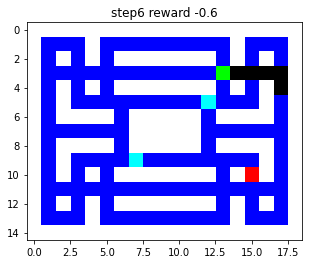

KeyboardInterrupt: ignored

In [14]:
MODES = ('regular', 'avoid', 'hunt', 'ambush', 'rush')
frame_cap = 1000

mode = 'rush'

env = MiniPacman(mode, 1000)

state = env.reset()
done = False

total_reward = 0
step = 1

displayImage(state.transpose(1, 2, 0), step, total_reward)

while not done:
    x =input()
    clear_output()
    try:
        keys[x]
    except:
        print("Only 'w' 'a' 'd' 's'")
        continue
    action = keys[x]
    
    next_state, reward, done, _ = env.step(action)
    total_reward += reward
    displayImage(next_state.transpose(1, 2, 0), step, total_reward)
    step += 1

In [0]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.autograd as autograd

In [0]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
USE_CUDA  = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args,**kwargs).cuda() if USE_CUDA else autograd.Variable(*args,**kwargs)


# **Actor Critic Algorithm**

# **Abstract A2C class**

In [0]:
class OnPolicy(nn.Module):
  def __init__(self):
    super(OnPolicy,self).__init__()
  def forward(self,x):
    raise NotImplementedError
  def act(self,x,deterministic=False):
    logit,value = self.forward(x)
    probs = F.softmax(logit)

    if deterministic:
      action = probs.max(1)[1]
    else:
      action = probs.multinomial()
    return action
  def evaluate_actions(self,x,action):
    logit,value = self.forward(x)
    probs = F.softmax(logit)
    log_probs = F.log_softmax(logit)
    action_log_probs = log_probs.gather(1,action)
    entropy = -(probs * log_probs).sum(1).mean()
    return logit,action_log_probs, value,entropy

# **Neural Network Architecture fot A2C**

In [0]:
class ActorCritic(OnPolicy):
  def __init__(self,in_shape,num_actions):
    super(ActorCritic,self).__init__()
    self.in_shape = in_shape
    self.features = nn.Sequential(
        nn.Conv2d(in_shape[0],16,kernel_size=3,stride=1),
        nn.ReLU(),
        nn.Conv2d(16,16,kernel_size=3,stride=2),
        nn.ReLU(),
    )
    self.fc = nn.Sequential(
        nn.Linear(self.feature_size(),256),
        nn.ReLU(),
    )
    self.critic = nn.Linear(256,1)
    self.actor = nn.Linear(256,num_actions)

  def forward(self,x):
    x = self.features(x)
    x = x.view(x.size(0),-1)
    x = self.fc(x)
    logit = self.actor(x)
    value = self.critic(x)
    return value, logit
  def feature_size(self):
    return self.features(autograd.Variable(torch.zeros(1, *self.in_shape))).view(1,-1).size(1)

# **Simple Class to Save experience for A2C critici**

In [0]:
class RolloutStorage(object):
    def __init__(self, num_steps, num_envs, state_shape):
        self.num_steps = num_steps
        self.num_envs  = num_envs
        self.states  = torch.zeros(num_steps + 1, num_envs, *state_shape)
        self.rewards = torch.zeros(num_steps,     num_envs, 1)
        self.masks   = torch.ones(num_steps  + 1, num_envs, 1)
        self.actions = torch.zeros(num_steps,     num_envs, 1).long()
        self.use_cuda = False
            
    def cuda(self):
        self.use_cuda  = True
        self.states    = self.states.cuda()
        self.rewards   = self.rewards.cuda()
        self.masks     = self.masks.cuda()
        self.actions   = self.actions.cuda()
        
    def insert(self, step, state, action, reward, mask):
        self.states[step + 1].copy_(state)
        self.actions[step].copy_(action)
        self.rewards[step].copy_(reward)
        self.masks[step + 1].copy_(mask)
        
    def after_update(self):
        self.states[0].copy_(self.states[-1])
        self.masks[0].copy_(self.masks[-1])
        
    def compute_returns(self, next_value, gamma):
        returns   = torch.zeros(self.num_steps + 1, self.num_envs, 1)
        if self.use_cuda:
            returns = returns.cuda()
        returns[-1] = next_value
        for step in reversed(range(self.num_steps)):
            returns[step] = returns[step + 1] * gamma * self.masks[step + 1] + self.rewards[step]
        return returns[:-1]

# **Creating Environment**

In [24]:
mode = "regular"
num_envs = 16
def make_env():
  def _thunk():
    env = MiniPacman(mode,1000)
    return env
  return _thunk
envs = [make_env() for i in range(num_envs)]
envs = SubprocVecEnv(envs)
state_shape = envs.observation_space.shape

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/usr/local/lib/python3.6/dist-packa

# **Init and Train**

In [0]:
gamma = 0.99
entropy_coef = 0.01
value_loss_coef = 0.5
max_grad_norm = 0.5
num_steps = 5
num_frames = int(10e5)

lr = 7e-4
eps = 1e-5
alpha = 0.99
actor_critic = ActorCritic(envs.observation_space.shape,envs.action_space.n)
optimizer = optim.RMSprop(actor_critic.parameters(),lr,eps=eps,alpha=alpha)
if USE_CUDA:
  actor_critic = actor_critic.cuda()

In [0]:
rollout = RolloutStorage(num_steps, num_envs, envs.observation_space.shape)
rollout.cuda()

all_rewards = []
all_losses  = []

In [0]:
state = envs.reset()
state = torch.FloatTensor(np.float32(state))

rollout.states[0].copy_(state)
episode_rewards = torch.zeros(num_envs,1)
final_rewards = torch.zeros(num_envs,1)
for i_update in range(num_frames):
  for step in range(num_steps):
    action = actor_critic.act(Variable(state))
    next_state,rewards,done, _= envs.step(action.sequeeze(1).cpu().data.numpy())
    reward = torch.FloatTensor(reward).unsequeeze(1)
    episode_rewards +=reward
    masks = torch.FloatTensor(1-np.array(done)).unsequeeze(1)
    final_rewards *= masks
    final_rewards += (1-masks) * episode_rewards
    episode_rewards *=masks

    if USE_CUDA:
      masks = masks.cuda()
    state = torch.FloatTensor(np.float32(next_state))
    rollout.insert(step,state,action.data,reward,mask)
  _, next_value = actor_critic(Variable(rollout.states[-1],volatile=True))
  next_value = next_value.data
  returns = rollout.compute_returns(next_value,gamma)
  logit,action_log_probs,values,entropy =actor_critic.evaluate_actions(
      Variable(rollout.states[:-1]).view(-1, *state_shape),
      Variable(rollout.actions).view(-1,1)
  )
  values = values.view(num_steps,num_envs,1)
  action_log_probs = action_log_probs.view(num_steps,num_envs,1)
  advantages = Variable(returns) - values

  value_loss = advantages.pow(2).mean()
  action_loss = -(Variable(advantages.data)*action_log_probs).mean()

  optimizer.zero_grad()
  loss = value_loss * value_loss_coef + action_loss - entropy * entropy_coef
  loss.backward()
  nn.utils.clip_grad_norm(actor_critic.parameters(),max_grad_norm)
  optimizer.step()

  if i_update % 100 ==0:
    all_rewards.append(final_rewards.mean())
    all_losses.append(loss.data[0])

    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('epoch %s. reward: %s'% (i_update,np.mean(all_rewards[-10:])))
    plt.plot(all_rewards)
    plt.subplot(132)
    plt.title('loss %s'% all_losses[-1])
    plt.plot(all_losses)
    plt.show()
  rollout.after_update()

# **Saving Model**

In [15]:
torch.save(actor_critic.state_dict(),"actor_critic_" + mode)

NameError: ignored

# **Let's see the Game**

In [0]:
import time
def displayImage(image,step,reward):
  clear_output(True)
  s = "step: " + str(step) + "reward: " +str(reward)
  plt.figure(figsize=(10,3))
  plt.title(s)
  plt.imshow(image)
  plt.show()
  time.sleep(0.1)

In [0]:
env = MiniPacman(mode,1000)
done =False
state = env.reset()
total_reward = 0
step = 1

while not done:
  current_state = torch.FloatTensor(state).unsequeeze(0)
  if USE_CUDA:
    current_state = current_state.cuda()
  action = actor_critic.act(Variable(current_state))
  next_state,reward,done,_ = env.step(action.data[0,0])
  total_reward +=reward
  state = next_state

  image = torch.FloatTensor(state).permute(1,2,0).cpu().numpy()
  displayImage(image,step,total_reward)
  step +=1

In [0]:

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
USE_CUDA = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args,**kwargs).cuda() if USE_CUDA else autograd.Variable(*args,**kwargs)

In [0]:
pixels = (
    (0.0,1.0,1.0),
    (0.0,1.0,0.0),
    (0.0,0.0,1.0),
    (1.0,1.0,1.0),
    (1.0,1.0,0.0),
    (0.0,0.0,0.0),
    (1.0,0.0,0.0),
)
pixel_to_categorical = {pix:i for i, pix in enumerate(pixels)}
num_pixels = len(pixels)
model_rewards = {
    "regular" :[0,1,2,3,4,5,6,7,8,9],
    "avoid"   :[0.1,-0.1,-5,-10,-20],
    "hunt"    :[0,1,10,-20],
    "ambush"  :[0,-0.1,10,-20],
    "rush"    :[0,-0.1,9.9]
}
reward_to_categorical = {mode : {reward:i for i, reward in enumerate(mode_rewards[mode])}for mode in 
                         mode_rewards.keys()}

In [0]:
def pix_to_target(next_states):
  target =[]
  for pixel in next_states.transpose(0,2,3,1).reshape(-1,3):
    target.append(pixel_to_categorical[tuple([np.ceil(pixel[0]),np.ceil(pixel[1]),np.ceil(pixel[2])])])
  return target
def target_to_pix(imagined_states):
  pixels =[]
  to_pixel = {value: key for key , value in pixel_to_categorical.items()}
  for target in imagined_states:
    pixels.append(list(to_pixel[target]))
  return np.array(pixels)
def rewards_to_target(mode,rewards):
  targets = []
  for reward in rewards:
    target.append(reward_to_categorical[mode][reward])
  return target
def plot(frame_idx,rewards,losses):
  clear_output(True)
  plt.figure(figsize=(20,5))
  plt.subplot(131)
  plt.title('loss %s' % losses[-1])
  plt.plot(losses)
  plt.show()
    
def displayImage(image, step, reward):
  s = str(step) + " " + str(reward)
  plt.title(s)
  plt.imshow(image)
  plt.show()

In [0]:
class BasicBlock(nn.Module):
  def __init__(self,in_shape,n1,n2,n3):
    super(BasicBlock,self).__init__()

    self.in_shape = in_shape
    self.n1 = n1
    self.n2 = n2
    self.n3 = n3
    self.maxpool = nn.MaxPool2d(kernel_size=in_shape[1:])
    self.conv1 = nn.Sequential(
        nn.Conv2d(in_shape[0]* 2, n1,kernel_size=1, stride = 2,padding=6),
        nn.ReLU(),
        nn.Conv2d(n1,n1,kernel_size=10,stride = 1, padding=(5,6)),
        nn.ReLU(),
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(in_shape[0] *2,n2,kernel_size=1),
        nn.ReLU(),
        nn.Conv2d(n2,n2,kernel_size=3,stride =1,padding=1),
        nn.ReLU(),
    )
    self.conv3 = nn.Sequential(
        nn.Conv2d(n1 + n2,n3,kernel_size=1),
        nn.ReLU(),
    )
  def forward(self,inputs):
    x = self.pool_and_inject(inputs)
    x = torch.cat([self.conv1(x),self.conv2(x)],1)
    x = self.conv3(x)
    x = torch.cat([x,inputs],1)
  def pool_and_inject(self,x):
    pooled = self.maxpool(x)
    tiled = pooled.expand((x.size(0),)+ self.in_shape)
    out = torch.cat([tiled,x],1)
    return out

In [0]:
class EnvModel(nn.Module):
  def __init__(self,in_shape,num_pixels,num_rewards):
    super(EnvModel,self).__init___()
    width = in_shape[1]
    height = in_shape[2]
    self.conv = nn.Sequential(
        nn.Conv2d(8,64,kernel_size=1),
        nn.ReLU()
    )
    self.basic_block1 = BasicBlock((64,width,height),16,32,64)
    self.basic_block2 = BasicBlock((128,width,height),16,32,64)
    self.image_conv = nn.Sequential(
        nn.Conv2d(192,256,kernel_size=1),
        nn.ReLU(),
        nn.Conv2d(64,64,kernel_size=1),
        nn.ReLU()
    )
    self.image_fc = nn.Linear(256,num_pixels)
    self.reward_conv = nn.Sequential(
        nn.Conv2d(192,64,kernel_size=1),
        nn.ReLU(),
        nn.Conv2d(64,64,kernel_size=1),
        nn.ReLU()
    )
    self.reward_fc = nn.Linear(64 * width * height, num_rewards)
  def forward(self,inputs):
    batch_size = input.size(0)
    x = self.conv(inputs)
    x = self.basic_block1(x)
    x = self.basic_block2(x)
    image = self.image_conv(x)
    image = image.permute(0,2,3,1).contiguous().view(-1,256)
    image = self.image_fc(image)

    reward = self.reward_conv(x)
    reward = reward.view(batch_size,-1)
    reward = self.reward_fc(reward)
    return image,reward

In [0]:
mode = "regular"
num_envs = 16
def make_env():
  def _thunk():
    env = MiniPacman(mode,1000)
  return _thunk
envs = [make_env() for i in range(num_envs)]
envs = SubprocVecEnv(envs)
state_shape = envs.observation_space.shape
num_actions = envs.actions_space.n

In [0]:
env_model    = EnvModel(envs.observation_space.shape, num_pixels, len(mode_rewards["regular"]))
actor_critic = ActorCritic(envs.observation_space.shape, envs.action_space.n)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(env_model.parameters())

if USE_CUDA:
    env_model    = env_model.cuda()
    actor_critic = actor_critic.cuda()

In [0]:
actor_critic.load_state_dict(torch.load("actor_critic_" + mode))

In [0]:
def get_action(state):
    if state.ndim == 4:
        state = torch.FloatTensor(np.float32(state))
    else:
        state = torch.FloatTensor(np.float32(state)).unsqueeze(0)
        
    action = actor_critic.act(Variable(state, volatile=True))
    action = action.data.cpu().squeeze(1).numpy()
    return action

In [0]:
def play_games(envs, frames):
    states = envs.reset()
    
    for frame_idx in range(frames):
        actions = get_action(states)
        next_states, rewards, dones, _ = envs.step(actions)
        
        yield frame_idx, states, actions, rewards, next_states, dones
        
        states = next_states

In [0]:
reward_coef = 0.1
num_updates = 5000

losses = []
all_rewards = []

for frame_idx, states, actions, rewards, next_states, dones in play_games(envs, num_updates):
    states      = torch.FloatTensor(states)
    actions     = torch.LongTensor(actions)

    batch_size = states.size(0)
    
    onehot_actions = torch.zeros(batch_size, num_actions, *state_shape[1:])
    onehot_actions[range(batch_size), actions] = 1
    inputs = Variable(torch.cat([states, onehot_actions], 1))
    
    if USE_CUDA:
        inputs = inputs.cuda()

    imagined_state, imagined_reward = env_model(inputs)

    target_state = pix_to_target(next_states)
    target_state = Variable(torch.LongTensor(target_state))
    
    target_reward = rewards_to_target(mode, rewards)
    target_reward = Variable(torch.LongTensor(target_reward))

    optimizer.zero_grad()
    image_loss  = criterion(imagined_state, target_state)
    reward_loss = criterion(imagined_reward, target_reward)
    loss = image_loss + reward_coef * reward_loss
    loss.backward()
    optimizer.step()
    
    losses.append(loss.data[0])
    all_rewards.append(np.mean(rewards))
    
    if frame_idx % 10 == 0:
        plot(frame_idx, all_rewards, losses)

In [0]:
torch.save(env_model.state_dict(), "env_model_" + mode)

In [0]:
import time

env = MiniPacman(mode, 1000)
batch_size = 1

done = False
state = env.reset()
iss = []
ss  = []

steps = 0

while not done:
    steps += 1
    actions = get_action(state)
    onehot_actions = torch.zeros(batch_size, num_actions, *state_shape[1:])
    onehot_actions[range(batch_size), actions] = 1
    state = torch.FloatTensor(state).unsqueeze(0)
    
    inputs = Variable(torch.cat([state, onehot_actions], 1))
    if USE_CUDA:
        inputs = inputs.cuda()

    imagined_state, imagined_reward = env_model(inputs)
    imagined_state = F.softmax(imagined_state)
    iss.append(imagined_state)
    
    next_state, reward, done, _ = env.step(actions[0])
    ss.append(state)
    state = next_state
    
    imagined_image = target_to_pix(imagined_state.view(batch_size, -1, len(pixels))[0].max(1)[1].data.cpu().numpy())
    imagined_image = imagined_image.reshape(15, 19, 3)
    state_image = torch.FloatTensor(next_state).permute(1, 2, 0).cpu().numpy()
    
    clear_output()
    plt.figure(figsize=(10,3))
    plt.subplot(131)
    plt.title("Imagined")
    plt.imshow(imagined_image)
    plt.subplot(132)
    plt.title("Actual")
    plt.imshow(state_image)
    plt.show()
    time.sleep(0.3)
    
    if steps > 30:
        break

In [0]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
USE_CUDA = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)

In [0]:
pixels = (
    (0.0, 1.0, 0.0), 
    (0.0, 1.0, 1.0),
    (0.0, 0.0, 1.0),
    (1.0, 1.0, 1.0),
    (1.0, 1.0, 0.0), 
    (0.0, 0.0, 0.0),
    (1.0, 0.0, 0.0)
)
pixel_to_onehot = {pix:i for i, pix in enumerate(pixels)} 
num_pixels = len(pixels)

task_rewards = {
    "regular": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    "avoid":   [0.1, -0.1, -5, -10, -20],
    "hunt":    [0, 1, 10, -20],
    "ambush":  [0, -0.1, 10, -20],
    "rush":    [0, -0.1, 9.9]
}
reward_to_onehot = {mode: {reward:i for i, reward in enumerate(task_rewards[mode])} for mode in task_rewards.keys()}

def pix_to_target(next_states):
    target = []
    for pixel in next_states.transpose(0, 2, 3, 1).reshape(-1, 3):
        target.append(pixel_to_onehot[tuple([np.round(pixel[0]), np.round(pixel[1]), np.round(pixel[2])])])
    return target

def target_to_pix(imagined_states):
    pixels = []
    to_pixel = {value: key for key, value in pixel_to_onehot.items()}
    for target in imagined_states:
        pixels.append(list(to_pixel[target]))
    return np.array(pixels)

def rewards_to_target(mode, rewards):
    target = []
    for reward in rewards:
        target.append(reward_to_onehot[mode][reward])
    return target
    
def displayImage(image, step, reward):
    s = str(step) + " " + str(reward)
    plt.title(s)
    plt.imshow(image)
    plt.show()

In [0]:
mode = "regular"
num_envs = 16

def make_env():
    def _thunk():
        env = MiniPacman(mode, 1000)
        return env

    return _thunk

envs = [make_env() for i in range(num_envs)]
envs = SubprocVecEnv(envs)

state_shape = envs.observation_space.shape
num_actions = envs.action_space.n
num_rewards = len(task_rewards[mode])

In [0]:
class RolloutEncoder(nn.Module):
  def __init__(self,in_shape,num_rewards,hidden_size):
    super(RolloutEncoder,self).__init__()
    self.in_shape = in_shape 
    self.features = nn.Sequential(
        nn.Conv2d(in_shape[0],16,kernel_size=3,stride=1),
        nn.ReLU(),
        nn.Conv2d(16,16,kernel_size=3,stride=2),
        nn.ReLU(),
    )
    self.gru = nn.GRU(self.feature_size()+ num_rewards,hidden_size)
  def forward(self,state,reward):
    num_steps = state.size(0)
    batch_size = state.size(1)
    state = state.view(-1,*self.in_shape)
    state = self.features(state)
    state = state.view(num_steps,batch_size,-1)
    rnn_input = torch.cat([state,reward],2)
    _, hidden = self.gru(rnn_input)
    return hidden.sequeeze(0)
  def feature_size(self):
    return self.features(autograd.Variable(torch.zeros(1, *self.in_shape))).view(1,-1).size(1)

In [0]:
class I2A(OnPolicy):
  def __init__(self,in_shape,num_actions,num_rewards,hidden_size,imagination,full_rollout = True):
    super(I2A,self).__init__()
    self.in_shape = in_shape
    self.num_actions = num_actions
    self.num_rewards = num_rewards
    self.imagination = imagination
    self.features = nn.Sequential(
        nn.Conv2d(in_shape[0],16,kernel_size=3,stride=1),
        nn.ReLU(),
        nn.Conv2d(16,16,kernel_size=3,stride=2),
        nn.ReLU(),
    )
    self.encoder = RolloutEncoder(in_shape,num_rewards,hidden_size)
    if full_rollout:
      self.fc = nn.Sequential(
          nn.Linear(self.feature_size() + num_actions * hidden_size, 256),
          nn.ReLU(),
      )
    else:
      self.fc = nn.Sequential(
          nn.Linear(self.feature_size() + hidden_size,256),
          nn.ReLU(),
      )
    self.critic = nn.Linear(256,1)
    self.actor = nn.Linear(256,num_actions)
  def forward(self,state):
    batch_size = state.size(0)
    imagined_state , imagined_reward = self.imagination(state.data)
    hidden = self.encoder(Variable(imagined_state),Variable(imagined_reward))
    state = self.features(state)
    state = state.view(state.size(0),-1)
    x = torch.cat([state,hidden],1)
    x = self.fc(x)
    logit = self.actor(x)
    value = self.critic(x)

    return logit,value
  def feature_size(self):
    return self.features(autograd.Variable(torch.zeros(1, *self.in_shape))).view(1,-1).size(1)

In [0]:
class ImaginationCore(object):
    def __init__(self, num_rolouts, in_shape, num_actions, num_rewards, env_model, distil_policy, full_rollout=True):
        self.num_rolouts  = num_rolouts
        self.in_shape      = in_shape
        self.num_actions   = num_actions
        self.num_rewards   = num_rewards
        self.env_model     = env_model
        self.distil_policy = distil_policy
        self.full_rollout  = full_rollout
        
    def __call__(self, state):
        state      = state.cpu()
        batch_size = state.size(0)

        rollout_states  = []
        rollout_rewards = []

        if self.full_rollout:
            state = state.unsqueeze(0).repeat(self.num_actions, 1, 1, 1, 1).view(-1, *self.in_shape)
            action = torch.LongTensor([[i] for i in range(self.num_actions)]*batch_size)
            action = action.view(-1)
            rollout_batch_size = batch_size * self.num_actions
        else:
            action = self.distil_policy.act(Variable(state, volatile=True))
            action = action.data.cpu()
            rollout_batch_size = batch_size

        for step in range(self.num_rolouts):
            onehot_action = torch.zeros(rollout_batch_size, self.num_actions, *self.in_shape[1:])
            onehot_action[range(rollout_batch_size), action] = 1
            inputs = torch.cat([state, onehot_action], 1)

            imagined_state, imagined_reward = self.env_model(Variable(inputs, volatile=True))

            imagined_state  = F.softmax(imagined_state).max(1)[1].data.cpu()
            imagined_reward = F.softmax(imagined_reward).max(1)[1].data.cpu()

            imagined_state = target_to_pix(imagined_state.numpy())
            imagined_state = torch.FloatTensor(imagined_state).view(rollout_batch_size, *self.in_shape)

            onehot_reward = torch.zeros(rollout_batch_size, self.num_rewards)
            onehot_reward[range(rollout_batch_size), imagined_reward] = 1

            rollout_states.append(imagined_state.unsqueeze(0))
            rollout_rewards.append(onehot_reward.unsqueeze(0))

            state  = imagined_state
            action = self.distil_policy.act(Variable(state, volatile=True))
            action = action.data.cpu()
        
        return torch.cat(rollout_states), torch.cat(rollout_rewards)

In [0]:
full_rollout = True

In [0]:
env_model     = EnvModel(envs.observation_space.shape, num_pixels, num_rewards)
env_model.load_state_dict(torch.load("env_model_" + mode))

distil_policy = ActorCritic(envs.observation_space.shape, envs.action_space.n)
distil_optimizer = optim.Adam(distil_policy.parameters())

imagination = ImaginationCore(1, state_shape, num_actions, num_rewards, env_model, distil_policy, full_rollout=full_rollout)

actor_critic = I2A(state_shape, num_actions, num_rewards, 256, imagination, full_rollout=full_rollout)
#rmsprop hyperparams:
lr    = 7e-4
eps   = 1e-5
alpha = 0.99
optimizer = optim.RMSprop(actor_critic.parameters(), lr, eps=eps, alpha=alpha)


if USE_CUDA:
    env_model     = env_model.cuda()
    distil_policy = distil_policy.cuda()
    actor_critic  = actor_critic.cuda()

In [0]:
gamma = 0.99
entropy_coef = 0.01
value_loss_coef = 0.5
max_grad_norm = 0.5
num_steps = 5
num_frames = int(10e5)

rollout = RolloutStorage(num_steps, num_envs, envs.observation_space.shape)
rollout.cuda()

all_rewards = []
all_losses  = []

In [0]:
state = envs.reset()
current_state = torch.FloatTensor(np.float32(state))

rollout.states[0].copy_(current_state)

episode_rewards = torch.zeros(num_envs, 1)
final_rewards   = torch.zeros(num_envs, 1)

for i_update in range(num_frames):

    for step in range(num_steps):
        if USE_CUDA:
            current_state = current_state.cuda()
        action = actor_critic.act(Variable(current_state))

        next_state, reward, done, _ = envs.step(action.squeeze(1).cpu().data.numpy())

        reward = torch.FloatTensor(reward).unsqueeze(1)
        episode_rewards += reward
        masks = torch.FloatTensor(1-np.array(done)).unsqueeze(1)
        final_rewards *= masks
        final_rewards += (1-masks) * episode_rewards
        episode_rewards *= masks

        if USE_CUDA:
            masks = masks.cuda()

        current_state = torch.FloatTensor(np.float32(next_state))
        rollout.insert(step, current_state, action.data, reward, masks)


    _, next_value = actor_critic(Variable(rollout.states[-1], volatile=True))
    next_value = next_value.data

    returns = rollout.compute_returns(next_value, gamma)

    logit, action_log_probs, values, entropy = actor_critic.evaluate_actions(
        Variable(rollout.states[:-1]).view(-1, *state_shape),
        Variable(rollout.actions).view(-1, 1)
    )
    
    distil_logit, _, _, _ = distil_policy.evaluate_actions(
        Variable(rollout.states[:-1]).view(-1, *state_shape),
        Variable(rollout.actions).view(-1, 1)
    )
        
    distil_loss = 0.01 * (F.softmax(logit).detach() * F.log_softmax(distil_logit)).sum(1).mean()

    values = values.view(num_steps, num_envs, 1)
    action_log_probs = action_log_probs.view(num_steps, num_envs, 1)
    advantages = Variable(returns) - values

    value_loss = advantages.pow(2).mean()
    action_loss = -(Variable(advantages.data) * action_log_probs).mean()

    optimizer.zero_grad()
    loss = value_loss * value_loss_coef + action_loss - entropy * entropy_coef
    loss.backward()
    nn.utils.clip_grad_norm(actor_critic.parameters(), max_grad_norm)
    optimizer.step()
    
    distil_optimizer.zero_grad()
    distil_loss.backward()
    optimizer.step()
    
    if i_update % 100 == 0:
        all_rewards.append(final_rewards.mean())
        all_losses.append(loss.data[0])
        
        clear_output(True)
        plt.figure(figsize=(20,5))
        plt.subplot(131)
        plt.title('epoch %s. reward: %s' % (i_update, np.mean(all_rewards[-10:])))
        plt.plot(all_rewards)
        plt.subplot(132)
        plt.title('loss %s' % all_losses[-1])
        plt.plot(all_losses)
        plt.show()
        
    rollout.after_update()

In [0]:
torch.save(actor_critic.state_dict(), "i2a_" + mode)